In [1]:
from torch import nn
import pandas as pd
import sqlite3
import torch
from torch import Tensor
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from tqdm import tqdm
import math
import numpy as np
import numpy as np
import pandas as pd
import sqlite3
import json
import math
import torch
import matplotlib.pyplot as plt
from dataclasses import dataclass
from torch_geometric.data import Data, InMemoryDataset
from sklearn.preprocessing import MinMaxScaler
from torchinfo import summary
import seaborn as sns
import os
import joblib
from simple_diffusion import Noiser, ImprovedNoiser, DDPMTrainer, ClimbDDPM, ClimbDDPMGenerator
from climb_conversion import ClimbsFeatureArray, ClimbsFeatureScaler

In [ ]:

class ClimbsFeatureArray:
    def __init__(
            self,
            db_path: str = "data/storage.db",
            to_length: int = 20,
            scaler_weights_path: str | None = None,
        ):
        """Gets climbs from the climbs database and converts them into featured Sequence data for our DDPM."""
        self.db_path = db_path
        self.to_length = to_length
        self.scaler = ClimbsFeatureScaler(weights_path=scaler_weights_path)
        self.null_token = [-2,0,-2,0,0,0,0,0,1]

        with sqlite3.connect(db_path) as conn:
            climbs_to_fit = pd.read_sql_query("SELECT * FROM climbs WHERE ascents > 1", conn, index_col='id')
            climbs_to_fit['holds'] = climbs_to_fit['holds'].apply(json.loads)
            climbs_to_fit = climbs_to_fit[climbs_to_fit['holds'].map(len) <= to_length]

            holds_to_fit = pd.read_sql_query("SELECT hold_index, x, y, pull_x, pull_y, useability, is_foot, wall_id FROM holds", conn)
            
            scaled_climbs, scaled_holds = self.scaler.fit_transform(climbs_to_fit, holds_to_fit)
            self.hold_features_df = scaled_holds
            self.holds_lookup = {
                wall_id: group.drop(columns=['wall_id','useability', 'is_foot', 'mult']).set_index('hold_index').to_dict('index')
                for wall_id, group in scaled_holds.groupby('wall_id')
            }
            self.climbs_df = scaled_climbs
        
        if scaler_weights_path:
            self.scaler.save_weights(scaler_weights_path)

    def apply_wall_angle(self, angle, val):
        rads = math.radians(angle)
        print(val, rads)
        return val * math.cos(rads), val * math.sin(rads)

    def _zero_center_of_mass(self, arr, dim=2, start_holds: list | None = None):
        """Return the center-of-mass of the climbing hold positions"""
        if start_holds is not None:
            com = np.mean(np.array(start_holds)[:,:dim], axis=0)
        else:
            com = np.mean(arr[:,:dim], axis=0)
        arr[:,:dim] -= com
        
        return arr

    def _2d_features(self, h_data):
        return [h_data['x'],h_data['y'], h_data['pull_x'], h_data['pull_y']]
    
    def _3d_features(self, h_data, angle):
        y, z = self.apply_wall_angle(h_data['y'], angle)
        py, pz = self.apply_wall_angle(h_data['pull_y'], angle)
        return [h_data['x'], y, z, h_data['pull_x'], py, pz]
    
    def get_features(self, dim=2, limit: int | None = None, continuous_only = True, augment_reflections=True):
        """Extract features from climbs"""
        assert dim in [2,3]

        x_out, cond_out, orig_climbs_out = [], [], []

        df = self.climbs_df.copy()
        if limit is not None:
            df = df.iloc[:limit,:]

        for _, row in df.iterrows():
            climb_holds = row['holds']
            wall_id = row['wall_id']
            angle = row['angle']
            try:
                wall_holds = self.holds_lookup[wall_id]
                start_holds=[]
                middle_holds=[]
                finish_holds=[]
                for h_idx, role in climb_holds:
                    h_data = wall_holds[h_idx]
                    feat = []
                    if dim==3:
                        feat = self._3d_features(h_data, angle)
                    elif dim==2:
                        feat = self._2d_features(h_data)
                    if not continuous_only:
                        role_vec = [0.0]*5
                        role_vec[role]=1.0
                        feat.extend(role_vec)
                    
                    match role:
                        case 0:
                            start_holds.append(feat)
                        case 1:
                            finish_holds.append(feat)
                        case _:
                            middle_holds.append(feat)
                if len(start_holds) > 2 or len(finish_holds) > 2:
                    raise ValueError(f"Start/Finish Hold list > 2 holds: {start_holds, finish_holds}")
                f_arr = np.array([
                    h
                    for hl in [start_holds, middle_holds, finish_holds]
                    for h in sorted(hl, key=(lambda x: x[0]+x[1]))
                ])

                f_arr = self._zero_center_of_mass(f_arr)
                
                pad_length = self.to_length - len(f_arr)
                if pad_length > 0:
                    null_token = self.null_token[:4] if continuous_only else self.null_token
                    null_holds = np.tile(np.array(null_token),(pad_length,1))
                    f_arr = np.concatenate([f_arr,null_holds], axis=0, dtype=np.float32)

                x_out.append(f_arr)
                cond_out.append([row['grade'], row['quality'], row['ascents'], angle])
                orig_climbs_out.append((climb_holds,wall_id))
            except KeyError:
                continue
        
        x_out = np.array(x_out)
        cond_out = np.array(cond_out)
        if augment_reflections:
            refl = x_out.copy()
            refl[:,:,[0, dim]] *= -1
            x_out = np.concatenate([x_out,refl],axis=0)
            cond_out = np.tile(cond_out,(2,1))
        
        return torch.FloatTensor(x_out), torch.FloatTensor(cond_out), orig_climbs_out

climbs = ClimbsFeatureArray('../data/storage.db')
dataset = climbs.get_features(limit = 10000, continuous_only=False)
# model = ClimbDDPM(ImprovedNoiser(64,3),predict_noise=True)
# trainer = DDPMTrainer(model,TensorDataset(*dataset), default_batch_size=256, lr=1e-4)
print(np.round(dataset[0][500].detach().numpy(),2), dataset[2][500])

[[ 0.38 -0.16 -0.12 -0.23  1.    0.    0.    0.    0.  ]
 [ 0.42  0.32 -0.   -0.47  1.    0.    0.    0.    0.  ]
 [-0.23 -0.59 -0.   -0.06  0.    0.    1.    0.    0.  ]
 [-0.36 -0.22 -0.   -0.47  0.    0.    0.    1.    0.  ]
 [ 0.16 -0.54 -0.   -0.06  0.    0.    1.    0.    0.  ]
 [-0.28  0.22 -0.03 -0.58  0.    0.    0.    1.    0.  ]
 [ 0.42 -0.32 -0.   -0.47  0.    0.    0.    1.    0.  ]
 [-0.1   0.22  0.05 -0.85  0.    0.    1.    0.    0.  ]
 [-0.14  0.27 -0.35  0.08  0.    0.    1.    0.    0.  ]
 [-0.01  0.22 -0.   -0.47  0.    0.    1.    0.    0.  ]
 [-0.1   1.08  0.03 -0.58  0.    0.    0.    1.    0.  ]
 [-0.14 -0.49 -0.   -0.47  0.    1.    0.    0.    0.  ]
 [-2.    0.   -2.    0.    0.    0.    0.    0.    1.  ]
 [-2.    0.   -2.    0.    0.    0.    0.    0.    1.  ]
 [-2.    0.   -2.    0.    0.    0.    0.    0.    1.  ]
 [-2.    0.   -2.    0.    0.    0.    0.    0.    1.  ]
 [-2.    0.   -2.    0.    0.    0.    0.    0.    1.  ]
 [-2.    0.   -2.    0.    0.  

In [ ]:
model2 = ClimbDDPM(Noiser(64,4),predict_noise=True)
trainer = DDPMTrainer(model,TensorDataset(*dataset), default_batch_size=256, lr=1e-4)
noiser2, losses2 = trainer.train(1000,'simple_diffusion1.pt')

  0%|          | 0/1000 [00:00<?, ?it/s]c:\Users\EvanM\Documents\Projects\GitHub\ml-homewall-climb-generator\model-training\equivariant_projected_diffusion\simple_diffusion.py:292: UserWarning: Using a target size (torch.Size([256, 20, 1])) that is different to the input size (torch.Size([256, 20, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(torch.square(pred_clean)*null_mask, null_mask*4)
 48%|████▊     | 480/1000 [19:33<21:33,  2.49s/it, Epoch: 479, Batches:25 Total Loss: 58.14, Real Hold Loss: 58.14, Null Hold Loss: 0.00, Improvement: 3.07]     

In [2]:
print(sum([p.numel() for p in Noiser().parameters()]))
print(sum([p.numel() for p in ImprovedNoiser().parameters()]))

1366980
4571012


In [ ]:
#With LR Scheduler
l1 = np.array([l[0] for l in losses])
l2 = np.array([l[0] for l in losses2])

fig, ax = plt.subplots(1,1,figsize=(8,8))

ax.plot(list(range(len(l1))),l1, label="Losses Improved Noiser")
ax.plot(list(range(len(l2))), l2, label="Losses Original Noiser")
ax.set_yscale('log')
ax.legend()
plt.show()

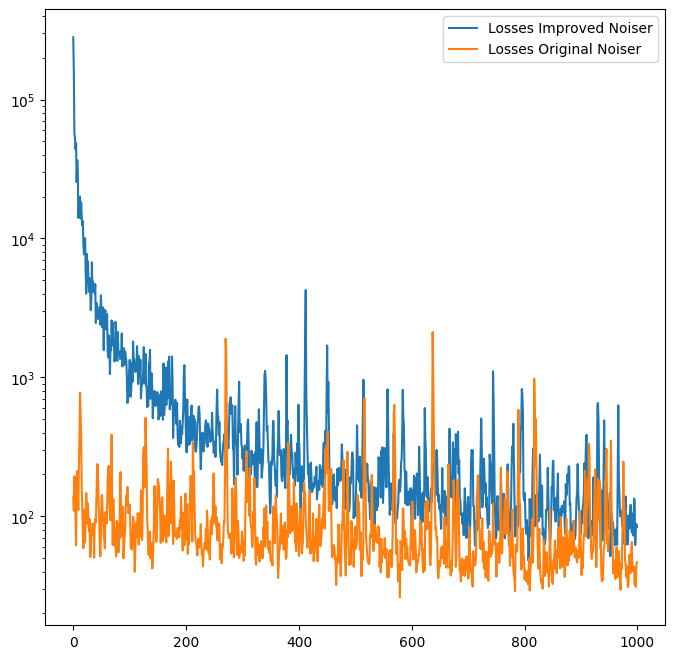

In [ ]:
# Without LR Scheduler
l1 = np.array([l[0] for l in losses])
l2 = np.array([l[0] for l in losses2])

fig, ax = plt.subplots(1,1,figsize=(8,8))

ax.plot(list(range(len(l1))),l1, label="Losses Improved Noiser")
ax.plot(list(range(len(l2))), l2, label="Losses Original Noiser")
ax.set_yscale('log')
ax.legend()
plt.show()

In [ ]:
print("Model 1 Params:", sum([p.numel() for p in model.parameters()]))
print("Model 2 Params:", sum([p.numel() for p in model2.parameters()]))

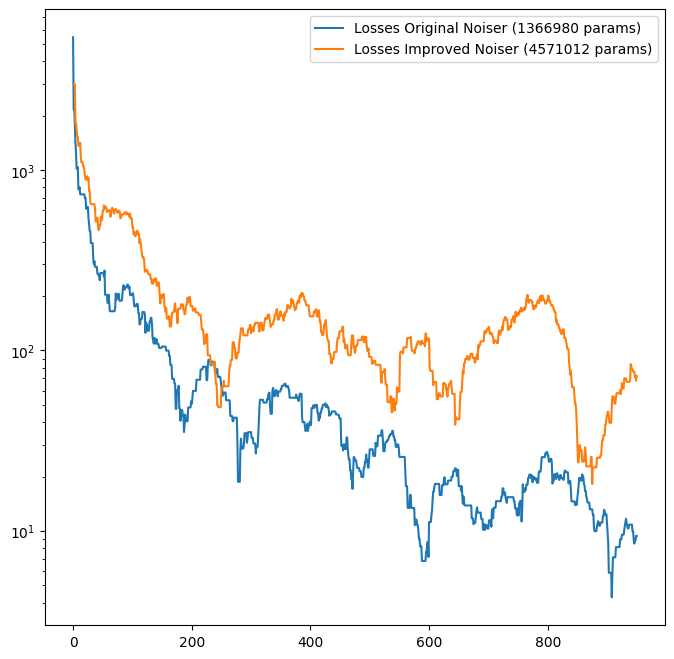

In [ ]:
#Test single-batch memorization to ensure both model architectures are working properly.
def test_single_batch(model: nn.Module, dataset: TensorDataset):
    optimizer = torch.optim.Adam(params = model.parameters())

    loader = DataLoader(dataset=dataset, batch_size=64)
    x, c = next(iter(loader))
    losses = []
    with tqdm(range(1000)) as pbar:
        for epoch in pbar:
            optimizer.zero_grad()
            loss = model.loss(x, c)
            loss.backward()
            grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            losses.append(loss.item())
            if epoch % 10 == 0:
                pbar.set_postfix_str(f"Loss: {loss.item():.4f}, Improvement:{losses[-1]-loss.item():.4f}, Grad Norm:{grad_norm:.4f}, Min loss:{min(losses) if len(losses) > 0 else 0:.5f}")
    print(f"Min loss:{min(losses):.5f}")
    return losses

def moving_average(values, window, gaussian = False):
    """
    Smooth values by doing a moving average
    :param values: (numpy array)
    :param window: (int)
    :return: (numpy array)
    """
    #We create the vector to multiply each value by to get the moving average. Essentially a vector of length n
    # in which each weight is 1/n.
    kernel = np.repeat(1.0, window) / window
    if (gaussian == True) :
        if window % 2 == 0:
            window+=1
        x = np.arange(-(window // 2), window // 2 + 1)
        kernel = np.exp(-(x ** 2) / (2 * window ** 2))
        kernel = kernel / np.sum(kernel)
    
    #The convolve function iteratively multiplies the first n values in the values array by the weights array.
    # with the given weights array, it essentially takes the moving average of each N values in the values array.
    return np.convolve(values, kernel, "valid")

climbs = ClimbsFeatureArray('../data/storage.db')
dataset = climbs.get_features(limit = 10000, augment_reflections=False)
losses1 = test_single_batch(ClimbDDPM(Noiser(), predict_noise=True),TensorDataset(*dataset))
losses2 = test_single_batch(ClimbDDPM(ImprovedNoiser(), predict_noise=True),TensorDataset(*dataset))

# Without LR Scheduler
l1 = moving_average(np.array(losses1), 50)
l2 = moving_average(np.array(losses2), 50)

fig, ax = plt.subplots(1,1,figsize=(8,8))

ax.plot(list(range(len(l1))), l1, label=f"Losses Original Noiser ({sum([p.numel() for p in Noiser().parameters()])} params)")
ax.plot(list(range(len(l2))), l2, label=f"Losses Improved Noiser ({sum([p.numel() for p in ImprovedNoiser().parameters()])} params)")
ax.set_yscale('log')
ax.legend()
plt.show()

100%|██████████| 1000/1000 [01:47<00:00,  9.33it/s, Loss: 0.0903, Improvement:0.0000, Grad Norm:1.2895, Min loss:0.06975]     


Min loss:0.06975


100%|██████████| 1000/1000 [01:47<00:00,  9.32it/s, Loss: 25.1519, Improvement:0.0000, Grad Norm:4099.2979, Min loss:0.12373]  


Min loss:0.11757


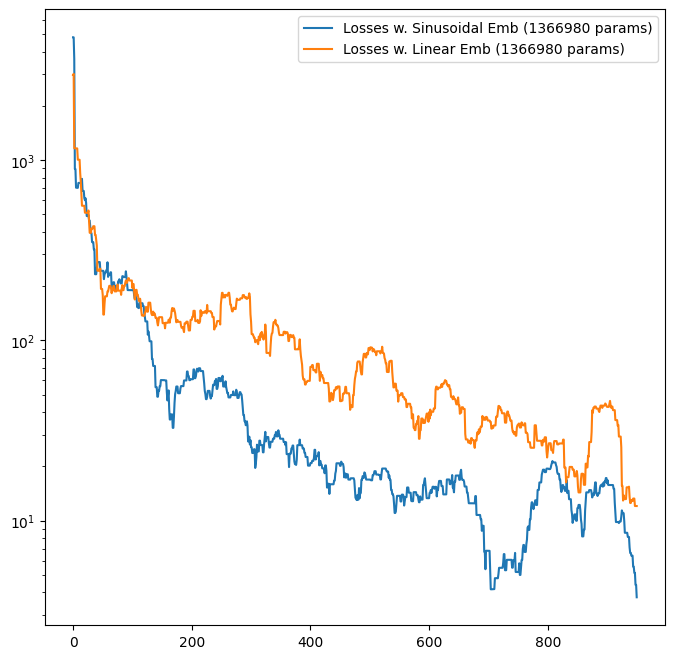

In [ ]:
#Test single-batch memorization to ensure both model architectures are working properly.
def test_single_batch(model: nn.Module, dataset: TensorDataset, steps: int = 1000, lr = 1e-3, decay=0.0):
    if decay == 0:
        optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
    else:
        optimizer = torch.optim.AdamW(params = model.parameters(), lr=lr, decay=decay)

    loader = DataLoader(dataset=dataset, batch_size=64)
    x, c = next(iter(loader))
    losses = []
    with tqdm(range(steps)) as pbar:
        for epoch in pbar:
            optimizer.zero_grad()
            loss = model.loss(x, c)
            loss.backward()
            grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            losses.append(loss.item())
            if epoch % 10 == 0:
                pbar.set_postfix_str(f"Loss: {loss.item():.4f}, Improvement:{losses[-1]-loss.item():.4f}, Grad Norm:{grad_norm:.4f}, Min loss:{min(losses) if len(losses) > 0 else 0:.5f}")
    print(f"Min loss:{min(losses):.5f}")
    return losses

def moving_average(values, window, gaussian = False):
    """
    Smooth values by doing a moving average
    :param values: (numpy array)
    :param window: (int)
    :return: (numpy array)
    """
    #We create the vector to multiply each value by to get the moving average. Essentially a vector of length n
    # in which each weight is 1/n.
    kernel = np.repeat(1.0, window) / window
    if (gaussian == True) :
        if window % 2 == 0:
            window+=1
        x = np.arange(-(window // 2), window // 2 + 1)
        kernel = np.exp(-(x ** 2) / (2 * window ** 2))
        kernel = kernel / np.sum(kernel)
    
    #The convolve function iteratively multiplies the first n values in the values array by the weights array.
    # with the given weights array, it essentially takes the moving average of each N values in the values array.
    return np.convolve(values, kernel, "valid")

climbs = ClimbsFeatureArray('../data/storage.db')
dataset = climbs.get_features(limit = 10000, augment_reflections=False)
losses1 = test_single_batch(ClimbDDPM(Noiser(sinusoidal=False), predict_noise=True),TensorDataset(*dataset))
losses2 = test_single_batch(ClimbDDPM(Noiser(), predict_noise=True),TensorDataset(*dataset))

# Without LR Scheduler
l1 = moving_average(np.array(losses1), 50)
l2 = moving_average(np.array(losses2), 50)

fig, ax = plt.subplots(1,1,figsize=(8,8))

ax.plot(list(range(len(l1))), l1, label=f"Losses w. Weight Decay ({sum([p.numel() for p in Noiser().parameters()])} params)")
ax.plot(list(range(len(l2))), l2, label=f"Losses w0. Weight Decay (lr=.001, {sum([p.numel() for p in Noiser().parameters()])} params)")
ax.set_yscale('log')
ax.legend()
plt.show()

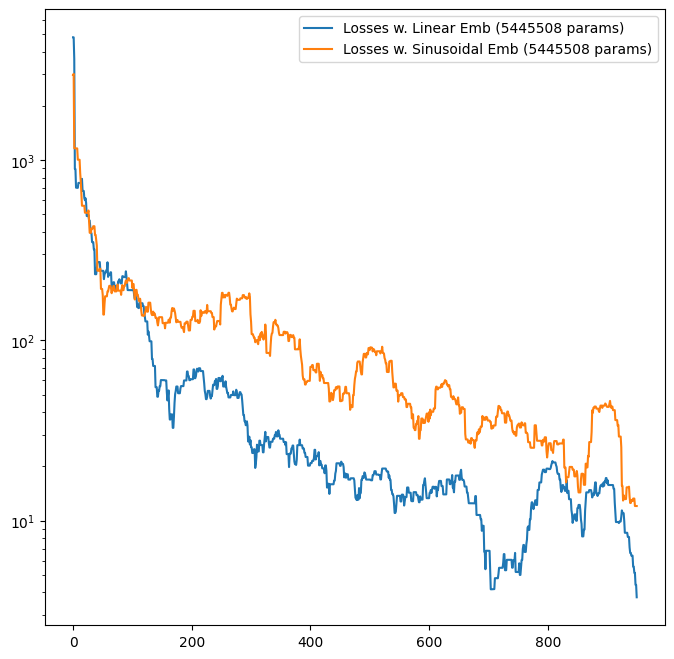

In [ ]:
# Test Sinusoidal Embedding on a medium-sized dataset.
climbs = ClimbsFeatureArray('../data/storage.db')
dataset = climbs.get_features(limit = 20000, augment_reflections=True)
losses1 = test_single_batch(ClimbDDPM(Noiser(128,sinusoidal=False), predict_noise=True),TensorDataset(*dataset), steps=3000)
losses2 = test_single_batch(ClimbDDPM(Noiser(128), predict_noise=True),TensorDataset(*dataset), steps=3000)

# Without LR Scheduler
l1 = moving_average(np.array(losses1), 50)
l2 = moving_average(np.array(losses2), 50)

fig, ax = plt.subplots(1,1,figsize=(8,8))

ax.plot(list(range(len(l1))), l1, label=f"Losses w. Linear Emb ({sum([p.numel() for p in Noiser(128).parameters()])} params)")
ax.plot(list(range(len(l2))), l2, label=f"Losses w. Sinusoidal Emb ({sum([p.numel() for p in Noiser(128).parameters()])} params)")
ax.set_yscale('log')
ax.legend()
plt.show()

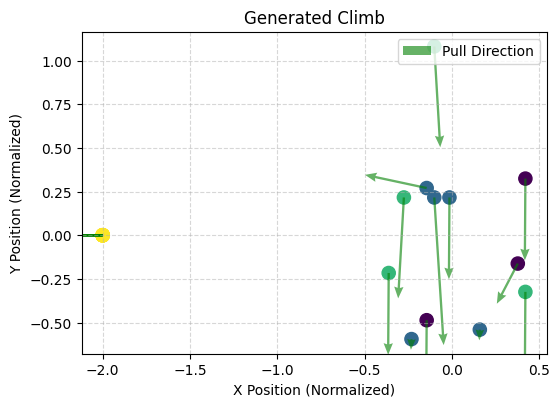

[(np.int64(0), np.float32(-0.16216215)),
 (np.int64(0), np.float32(0.3243243)),
 (np.int64(1), np.float32(-0.5945946)),
 (np.int64(2), np.float32(-0.21621622)),
 (np.int64(1), np.float32(-0.5405405)),
 (np.int64(2), np.float32(0.21621622)),
 (np.int64(2), np.float32(-0.3243243)),
 (np.int64(1), np.float32(0.21621622)),
 (np.int64(1), np.float32(0.27027026)),
 (np.int64(1), np.float32(0.21621622)),
 (np.int64(2), np.float32(1.081081)),
 (np.int64(0), np.float32(-0.4864865)),
 (np.int64(3), np.float32(0.0)),
 (np.int64(3), np.float32(0.0)),
 (np.int64(3), np.float32(0.0)),
 (np.int64(3), np.float32(0.0)),
 (np.int64(3), np.float32(0.0)),
 (np.int64(3), np.float32(0.0)),
 (np.int64(3), np.float32(0.0)),
 (np.int64(3), np.float32(0.0))]

In [21]:
def plot_climb(climb_data, title="Generated Climb"):
    """
    Visualizes a climb generated by a neural network.
    
    Args:
        climb_data (np.array): Shape [N, 4|9]. 
                               Features: [x, y, pull_x, pull_y, role_emb]
        title (str): Title for the plot.
    """
    role = np.argmax(climb_data[:,5:], axis=1)
    x, y, pull_x, pull_y = climb_data[:,:4].T

    # 2. Setup the Plot
    # Climbing walls are vertical, so we use a tall figsize
    fig, ax = plt.subplots(figsize=(6, 8))
    
    # 3. Plot Hand Holds (Circles, Blue)
    # We filter using the inverted boolean mask
    ax.scatter(x, y, c=role, s=90)

    # 5. Plot Pull Vectors (Arrows)
    # quiver(x, y, u, v) plots arrows at (x,y) with direction (u,v)
    ax.quiver(x, y, pull_x, pull_y, 
              color='green', alpha=0.6, 
              angles='xy', scale_units='xy', scale=1, 
              width=0.005, headwidth=4,
              label='Pull Direction', zorder=1)

    # 6. Formatting
    ax.set_title(title)
    ax.set_xlabel("X Position (Normalized)")
    ax.set_ylabel("Y Position (Normalized)")
    
    # Important: set aspect to 'equal' so the wall doesn't look stretched
    ax.set_aspect('equal')
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.legend(loc='upper right')


    plt.show()
    return list(zip(role, y))


# climb = ClimbDDPMGenerator(
#     model = ClimbDDPM(model=Noiser(hidden_dim=512, layers=8), predict_noise=True),
#     scaler = ClimbsFeatureScaler(),
#     wall_id = 'wall-0a877f13d8e5',
#     db_path = '../data/storage.db',
#     model_weights_path = 'simple-diffusion-large.pth',
#     scaler_weights_path = 'climb_ddpm_scaler.joblib'
# ).generate().detach().numpy().reshape(-1,4)
# print(np.round(climb,2))
plot_climb(climb.detach().numpy())

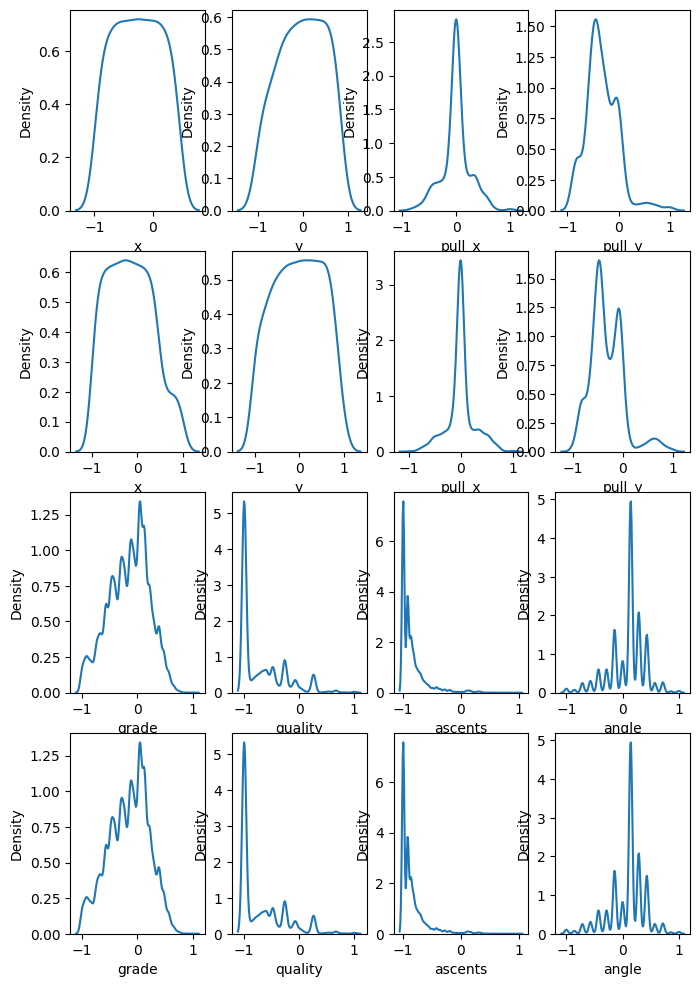

In [54]:
class ClimbsFeatureScaler:
    def __init__(self, weights_path: str | None = None):
        self.cond_features_scaler = MinMaxScaler(feature_range=(-1,1))
        self.hold_features_scaler = MinMaxScaler(feature_range=(-1,1))
        if weights_path and os.path.exists(weights_path):
            self.load_weights(weights_path)
    def save_weights(self, path: str):
        """Save weights to weights path."""
        state = {
            'cond_scaler': self.cond_features_scaler,
            'hold_scaler': self.hold_features_scaler
        }
        joblib.dump(state, path)
    
    def load_weights(self, path: str):
        """Load saved MinMaxScaler weights from the weights path."""
        state = joblib.load(path)
        self.cond_features_scaler = state['cond_scaler']
        self.hold_features_scaler = state['hold_scaler']
        
    def fit_transform(self, climbs_to_fit: pd.DataFrame, holds_to_fit: pd.DataFrame):
        """Function for fitting the MinMax scalers to the climbs and holds dataframes and returning the transformed climbs and holds df"""
        # Fit preprocessing steps for climbs DF
        scaled_climbs = climbs_to_fit.copy()
        scaled_climbs = self._apply_log_transforms(scaled_climbs)
        scaled_climbs[['grade','quality','ascents','angle']] = self.cond_features_scaler.fit_transform(scaled_climbs[['grade','quality','ascents','angle']])
        # For holds DF
        scaled_holds = self._apply_hold_transforms(holds_to_fit.copy())
        scaled_holds[['x','y','pull_x','pull_y']] = self.hold_features_scaler.fit_transform(scaled_holds[['x','y','pull_x','pull_y']])
        
        return (scaled_climbs, scaled_holds)
    
    def _apply_log_transforms(self, dfc: pd.DataFrame) -> pd.DataFrame:
        """Covers Log transformation logic"""
        dfc['quality'] -= 3
        dfc['quality'] = np.log(1-dfc['quality'])
        dfc['ascents'] = np.log(dfc['ascents'])

        return dfc
    
    def _apply_hold_transforms(self, dfh: pd.DataFrame) -> pd.DataFrame:
        """Covers useability and is_foot embedding logic"""
        dfh['mult'] = dfh['useability'] / ((3 * dfh['is_foot'])+1)
        dfh['pull_x'] *= dfh['mult']
        dfh['pull_y'] *= dfh['mult']
        return dfh
    
    def transform_climb_features(self, dfc: pd.DataFrame, to_df: bool = False):
        """Turn a series of conditional climb features into normalized features for the DDPM."""
        dfc = self._apply_log_transforms(dfc)
        if to_df:
            dfc[['grade','quality','ascents','angle']] = self.cond_features_scaler.transform(dfc[['grade','quality','ascents','angle']])
        else:
            dfc = self.cond_features_scaler.transform(dfc[['grade','quality','ascents','angle']])

        return dfc
    
    def transform_hold_features(self, dfh: pd.DataFrame, to_df:bool=False):
        """Turn a series of hold features into normalized features for the DDPM."""
        dfh = self._apply_hold_transforms(dfh)
        if to_df:
            dfh[['x','y','pull_x','pull_y']] = self.hold_features_scaler.transform(dfh[['x','y','pull_x','pull_y']])
        else:
            dfh = self.hold_features_scaler.transform(dfh[['x','y','pull_x','pull_y']])

        return dfh

weights_path = 'climb_ddpm_scaler.joblib'
db_path = '../data/storage.db'
to_length = 20
with sqlite3.connect(db_path) as conn:
    query = "SELECT * FROM climbs WHERE ascents > 1"
    all_climbs = pd.read_sql_query(query, conn, index_col='id')
    all_holds = pd.read_sql_query("SELECT hold_index, x, y, pull_x, pull_y, useability, is_foot, wall_id FROM holds",conn)
    scaler = ClimbsFeatureScaler()
    scaled_climbs, scaled_holds = scaler.fit_transform(all_climbs,all_holds)
    scaler.save_weights(weights_path)

scaler = ClimbsFeatureScaler()
scaler.load_weights(weights_path)
rescaled_holds = scaler.transform_hold_features(all_holds[all_holds['wall_id']=='wall-443c15cd12e0'], to_df=False)
rescaled_climbs = scaler.transform_climb_features(all_climbs, to_df=False)

dfh = pd.DataFrame(rescaled_holds,columns=['x','y','pull_x','pull_y'])
dfhs = pd.DataFrame(scaled_holds,columns=['x','y','pull_x','pull_y'])
dfc = pd.DataFrame(rescaled_climbs,columns=['grade','quality','ascents','angle'])
dfcs = pd.DataFrame(scaled_climbs,columns=['grade','quality','ascents','angle'])
fig, axes = plt.subplots(4,4, figsize=(8,12))

for i, c in enumerate(dfh.columns):
    sns.kdeplot(dfh, x=c, ax=axes[0][i%4])
for i, c in enumerate(dfhs.columns):
    sns.kdeplot(dfhs, x=c, ax=axes[1][i%4])
for i, c in enumerate(dfc.columns):
    sns.kdeplot(dfc, x=c, ax=axes[2][i%4])
for i, c in enumerate(dfcs.columns):
    sns.kdeplot(dfcs, x=c, ax=axes[3][i%4])

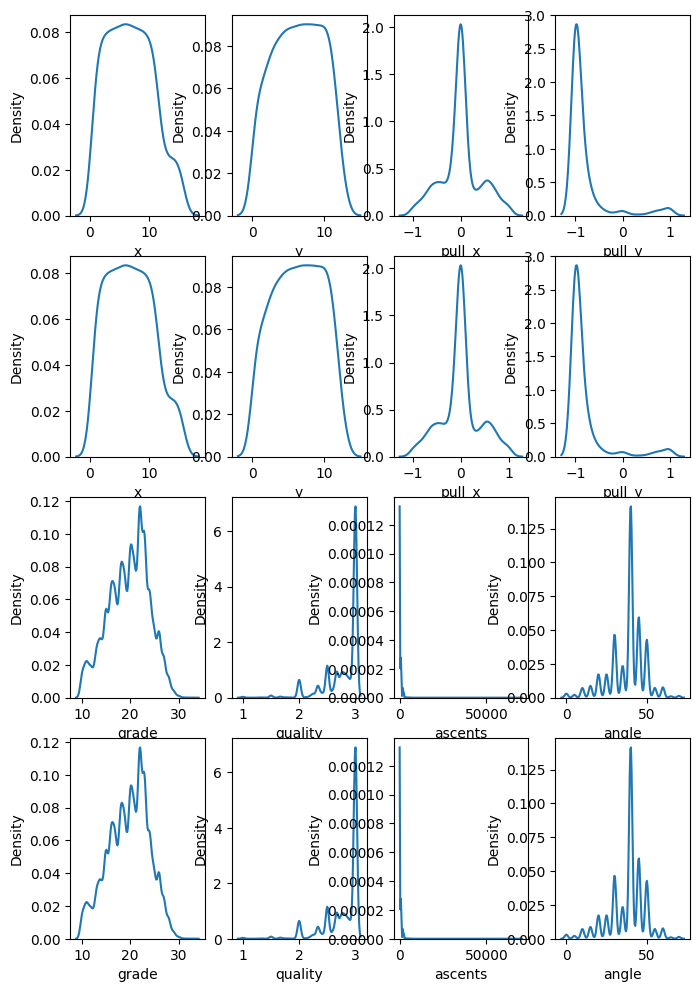

In [43]:
n = 4
df_cond = pd.DataFrame({"grade":[24]*n,"quality":[3]*n,"ascents":[1000]*n,"angle":[45]*n})
scaler = ClimbsFeatureScaler(weights_path='climb_ddpm_scaler.joblib')
scaled_cond = scaler.preprocess_conditional_features(df_cond)
scaled_cond.shape

(4, 4)

In [7]:
with sqlite3.connect("../data/boardlib/tension.db") as conn:
    dfd = pd.read_sql_query("SELECT * FROM difficulty_grades WHERE is_listed = 1",conn)
dfd.head()

,difficulty,boulder_name,route_name,is_listed
0,10,4a/V0,5b/5.9,1
1,11,4b/V0,5c/5.10a,1
2,12,4c/V0,6a/5.10b,1
3,13,5a/V1,6a+/5.10c,1
4,14,5b/V1,6b/5.10d,1


In [13]:
v_grades = []
font_grades = []
for l in dfd['boulder_name'].str.split('/'):
    font_grades.append(l[0])
    v_grades.append(l[1])

font_to_diff = list(zip(v_grades,dfd['difficulty']))
font_to_diff

[('V0', 10),
 ('V0', 11),
 ('V0', 12),
 ('V1', 13),
 ('V1', 14),
 ('V2', 15),
 ('V3', 16),
 ('V3', 17),
 ('V4', 18),
 ('V4', 19),
 ('V5', 20),
 ('V5', 21),
 ('V6', 22),
 ('V7', 23),
 ('V8', 24),
 ('V8', 25),
 ('V9', 26),
 ('V10', 27),
 ('V11', 28),
 ('V12', 29),
 ('V13', 30),
 ('V14', 31),
 ('V15', 32),
 ('V16', 33)]

In [14]:
dict([('V0-', 10),
 ('V0', 11),
 ('V0+', 12),
 ('V1', 13),
 ('V1+', 14),
 ('V2', 15),
 ('V3', 16),
 ('V3+', 17),
 ('V4', 18),
 ('V4+', 19),
 ('V5', 20),
 ('V5+', 21),
 ('V6', 22),
 ('V6+', 22.5),
 ('V7', 23),
 ('V7+', 23.5),
 ('V8', 24),
 ('V8+', 25),
 ('V9', 26),
 ('V9+', 26.5),
 ('V10', 27),
 ('V10+', 27.5),
 ('V11', 28),
 ('V11+', 28.5),
 ('V12', 29),
 ('V12+', 29.5),
 ('V13', 30),
 ('V13+', 30.5),
 ('V14', 31),
 ('V14+', 31.5),
 ('V15', 32),
 ('V15+', 32.5),
 ('V16', 33)])

{'V0-': 10,
 'V0': 11,
 'V0+': 12,
 'V1': 13,
 'V1+': 14,
 'V2': 15,
 'V3': 16,
 'V3+': 17,
 'V4': 18,
 'V4+': 19,
 'V5': 20,
 'V5+': 21,
 'V6': 22,
 'V6+': 22.5,
 'V7': 23,
 'V7+': 23.5,
 'V8': 24,
 'V8+': 25,
 'V9': 26,
 'V9+': 26.5,
 'V10': 27,
 'V10+': 27.5,
 'V11': 28,
 'V11+': 28.5,
 'V12': 29,
 'V12+': 29.5,
 'V13': 30,
 'V13+': 30.5,
 'V14': 31,
 'V14+': 31.5,
 'V15': 32,
 'V15+': 32.5,
 'V16': 33}